**Import librerie**

In [1]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image

print(torch.__version__)
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

2.4.1+cu121
False
cpu


In [2]:
#os.remove('/kaggle/working/checkpoint.pth')
#os.remove('/kaggle/working/training_history.json')

(480, 640, 3) (480, 640, 3)


Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

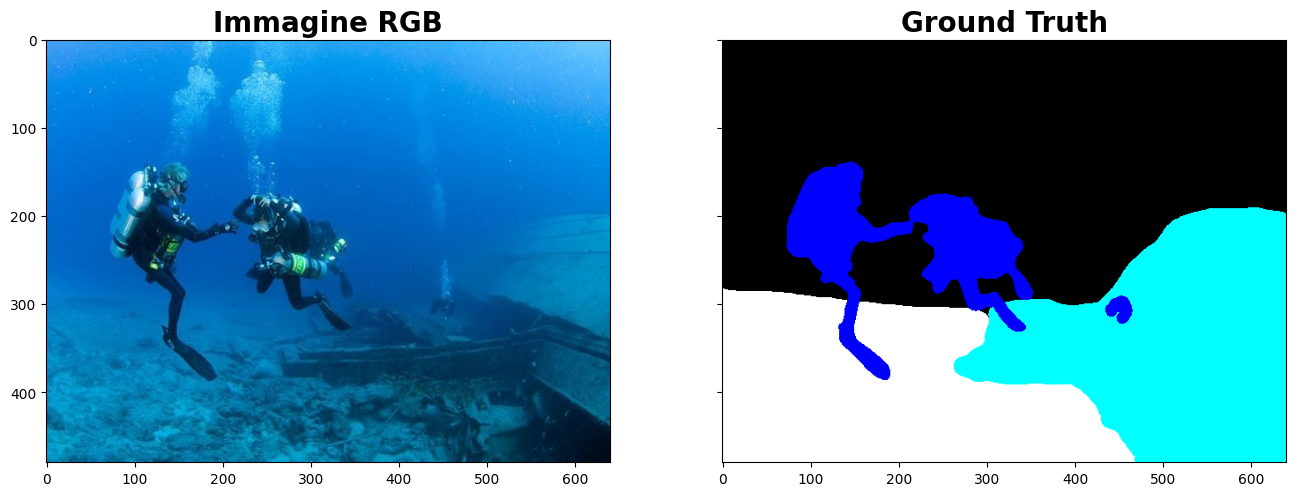

In [2]:
img = imageio.imread('/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/images/d_r_103_.jpg')
gt = imageio.imread('/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks/d_r_103_.bmp')

print(img.shape, gt.shape)

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(img)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(gt)
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')


In [3]:
class_dict = {
    0: 'Background (waterbody) BW',
    1: 'Robots (AUVs/ROVs/instruments) RO',
    2: 'Aquatic plants and sea-grass PF',
    3: 'Human divers HD',
    4: 'Reefs and invertebrates RI',
    5: 'Wrecks and ruins WR',
    6: 'Fish and vertebrates FV',
    7: 'Sea-floor and rocks SR',
}

(480, 640)


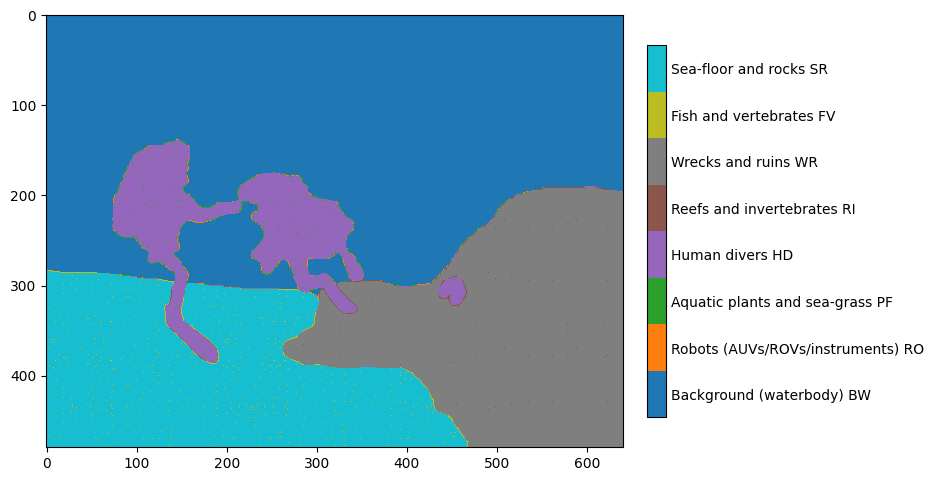

In [4]:
import matplotlib.colors as mcolors
from matplotlib import colors


# Mappatura da colori a valori
color_to_value = {
    (0, 0, 0): 0,        # Background (waterbody) BW
    (255, 0, 0): 1,      # Robots (AUVs/ROVs/instruments) RO
    (0, 255, 0): 2,      # Aquatic plants and sea-grass PF
    (0, 0, 255): 3,      # Human divers HD
    (255, 0, 255): 4,    # Reefs and invertebrates RI
    (0, 255, 255): 5,    # Wrecks and ruins WR
    (255, 255, 0): 6,    # Fish and vertebrates FV
    (255, 255, 255): 7,  # Sea-floor and rocks SR
}

# Funzione per convertire la maschera
def convert_mask_from_array(mask_array):

    mask_array = np.array(mask_array)
    # Crea una nuova maschera vuota
    new_mask = np.zeros(mask_array.shape[:2], dtype=np.uint8)

    # Applica la mappatura
    for color, value in color_to_value.items():
        new_mask[np.all(mask_array == color, axis=-1)] = value
    
    return new_mask

# Esempio di utilizzo

gt = np.array(gt)  # Converti l'immagine in array NumPy

# Converte la maschera
converted_mask = convert_mask_from_array(gt)

print(converted_mask.shape)

def print_mask(ax, converted_mask):
    # Definisci i limiti per la colorbar
    bounds = np.arange(0, 9)  # 8 classi, quindi da 0 a 8
    
    # Crea la colormap con i primi 8 colori di tab10
    cmap = plt.get_cmap('tab10', 8)
    
    # Crea una normalizzazione per mappare i valori delle classi ai colori
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # Crea l'immagine con la maschera convertita
    cax = ax.imshow(converted_mask, cmap=cmap, norm=norm)
    
    # Crea la barra dei colori con la normalizzazione e i limiti definiti
    cbar = plt.colorbar(cax, ticks=np.arange(8), ax=ax, fraction=0.03, pad=0.04)
    
    # Imposta la posizione dei ticks (al centro dei colori)
    cbar.ax.set_yticks(np.arange(8) + 0.5)  # Sposta i ticks verso il centro del colore
    
    # Imposta i nomi delle classi sulla colorbar
    cbar.ax.set_yticklabels([class_dict[i] for i in class_dict.keys()])
      
    # Rimuovi i tick dalla parte inferiore
    cbar.ax.tick_params(axis='y', which='both', length=0)  # Rimuove i tick dalla parte inferiore


#Creazione della figura
fig, ax = plt.subplots(figsize=(8, 8))

# Usa la funzione `print_mask` per visualizzare la maschera nell'asse axs[1]
print_mask(ax, converted_mask)

# Mostra la figura
plt.show()

# Dataset

train: 1373 immagini e 1373 maschere


<Figure size 640x480 with 0 Axes>

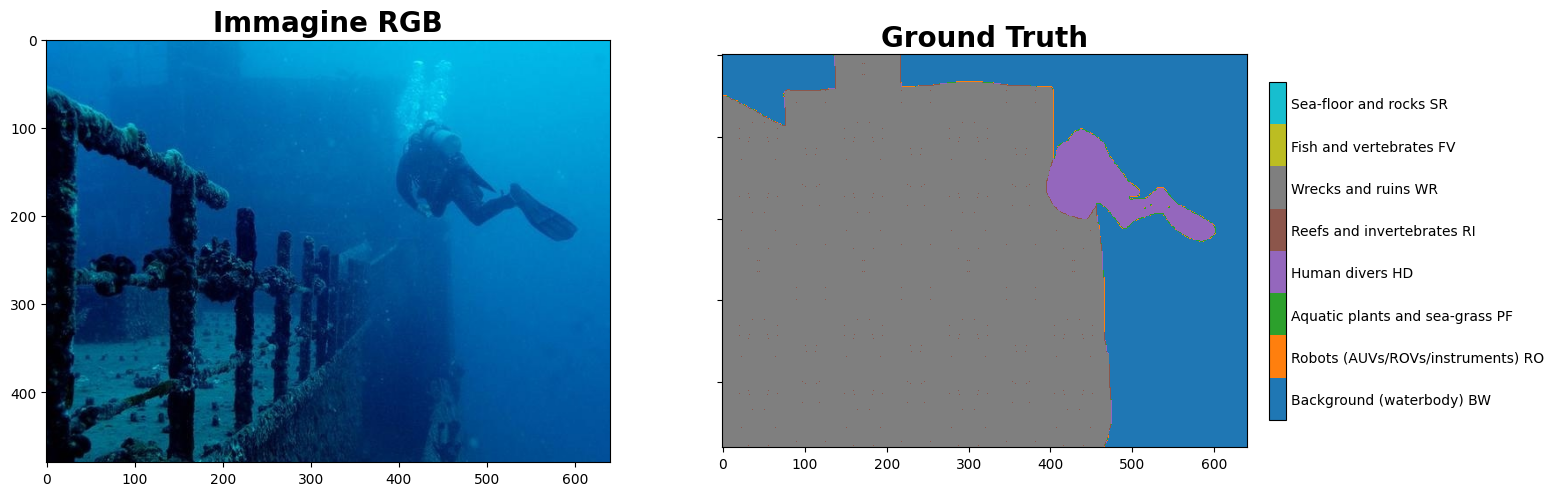

validation: 152 immagini e 152 maschere


<Figure size 640x480 with 0 Axes>

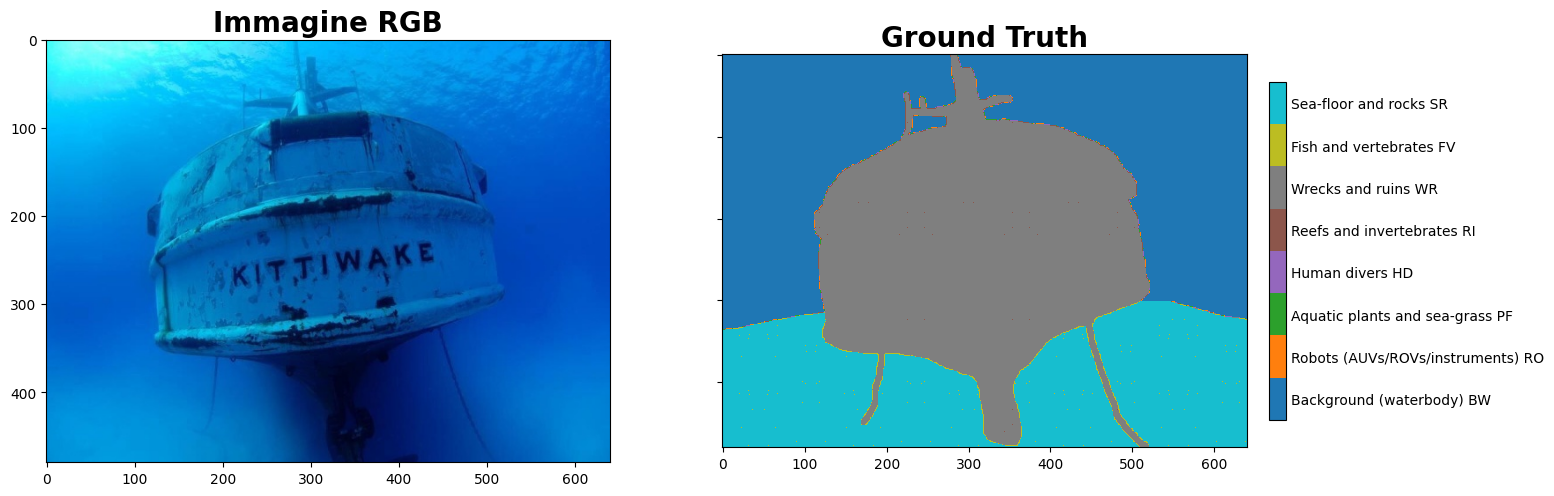

test: 110 immagini e 110 maschere


<Figure size 640x480 with 0 Axes>

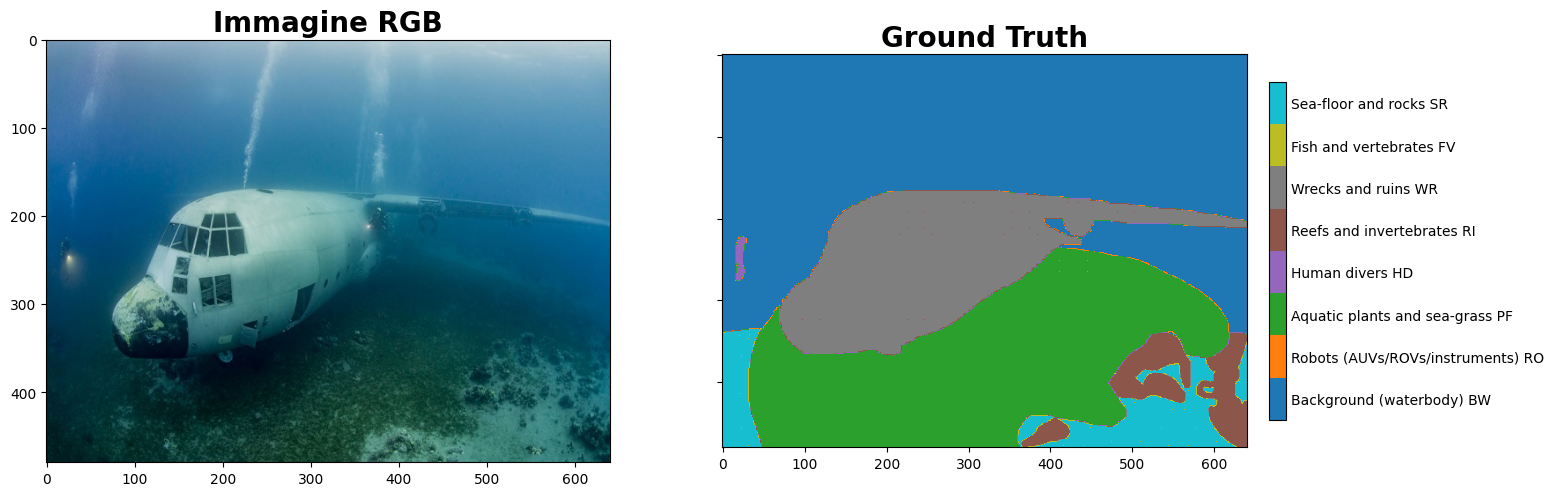

In [5]:
import shutil

root = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val'
images = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/images"
masks = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks"
test_images = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images"
test_masks = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/masks"

# Ottieni tutti i file nelle cartelle
image_files = sorted(os.listdir(images))
mask_files = sorted(os.listdir(masks))

num_files = len(image_files)
num_val_files = int(0.1 * num_files)  # Calcola il 10% dei file

# Seleziona ogni X-esima immagine per la validazione
X = 10  # Imposta X al numero di file che vuoi saltare (es. 1 ogni 10)
val_image_files = image_files[::X][:num_val_files]  # Seleziona ogni X-esima immagine
val_mask_files = mask_files[::X][:num_val_files]  # Seleziona la maschera corrispondente

# Crea le liste con i percorsi completi per il training e la validazione
img_path_train = [os.path.join(images, f) for f in image_files if f not in val_image_files]
gt_path_train = [os.path.join(masks, f) for f in mask_files if f not in val_mask_files]

img_path_val = [os.path.join(images, f) for f in val_image_files]
gt_path_val = [os.path.join(masks, f) for f in val_mask_files]


# Carica un'immagine e la sua maschera
img = imageio.imread(img_path_train[-1])  # Assicurati che l'indice sia corretto
gt = imageio.imread(gt_path_train[-1])

converted_mask = convert_mask_from_array(gt)

print(f'train: {len(img_path_train)} immagini e {len(gt_path_train)} maschere')


# Mostra l'immagine e la sua maschera
plt.figure()
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 7))
axs[0].imshow(img)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')

axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')
print_mask(axs[1], converted_mask)
plt.show()

print(f'validation: {len(img_path_val)} immagini e {len(gt_path_val)} maschere')

# Carica un'immagine e la sua maschera
img2 = imageio.imread(img_path_val[-1])  # Assicurati che l'indice sia corretto
gt2 = imageio.imread(gt_path_val[-1])

converted_mask2 = convert_mask_from_array(gt2)

# Mostra l'immagine e la sua maschera
plt.figure()
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 7))
axs[0].imshow(img2)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')

axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')
print_mask(axs[1], converted_mask2)
plt.show()

########################### TEST

# Ottieni tutti i file nelle cartelle
image_files_test = sorted(os.listdir(test_images))
mask_files_test = sorted(os.listdir(test_masks))

# Scarta le prime 8 maschere
mask_files_test = mask_files_test[8:]

# Crea le liste con i percorsi completi per le immagini e maschere rimanenti
img_path_test = [os.path.join(test_images, f) for f in image_files_test]
gt_path_test = [os.path.join(test_masks, f) for f in mask_files_test]

# Carica un'immagine e la sua maschera
img3 = imageio.imread(img_path_test[-1])  # Assicurati che l'indice sia corretto
gt3 = imageio.imread(gt_path_test[-1])

converted_mask3 = convert_mask_from_array(gt3)

print(f'test: {len(img_path_test)} immagini e {len(gt_path_test)} maschere')


# Mostra l'immagine e la sua maschera
plt.figure()
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 7))
axs[0].imshow(img3)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')

axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')
print_mask(axs[1], converted_mask3)
plt.show()



In [9]:
'''

import os
from PIL import Image
import torchvision.transforms as T

# Funzione per eseguire i crop consecutivi (non casuali) come descritto
def custom_crop(image, gt, crop_size=(360, 360)):
    """
    Esegue un crop su immagine e target in modo consecutivo (non casuale).
    Se l'immagine è abbastanza grande, esegue tre crop separati lungo l'asse orizzontale e verticale.
    """
    width, height = image.size
    crops = []

    # Esegui tre crop consecutivi lungo l'asse orizzontale
    if width >= 3 * crop_size[0] and height >= crop_size[1]:
        for i in range(3):  # 3 crop consecutivi lungo l'asse orizzontale
            x1 = i * crop_size[0]
            y1 = 0
            crop = image.crop((x1, y1, x1 + crop_size[0], y1 + crop_size[1]))
            target_crop = gt.crop((x1, y1, x1 + crop_size[0], y1 + crop_size[1]))
            crops.append((crop, target_crop))

    # Esegui due crop consecutivi se possibile
    elif width >= 2 * crop_size[0] and height >= crop_size[1]:
        for i in range(2):  # 2 crop consecutivi lungo l'asse orizzontale
            x1 = i * crop_size[0]
            y1 = 0
            crop = image.crop((x1, y1, x1 + crop_size[0], y1 + crop_size[1]))
            target_crop = gt.crop((x1, y1, x1 + crop_size[0], y1 + crop_size[1]))
            crops.append((crop, target_crop))

    # Altrimenti, esegui un singolo crop
    else:
        x1 = 0
        y1 = 0
        crop = image.crop((x1, y1, x1 + crop_size[0], y1 + crop_size[1]))
        target_crop = gt.crop((x1, y1, x1 + crop_size[0], y1 + crop_size[1]))
        crops.append((crop, target_crop))

    return crops

# Funzione per salvare i crop in una cartella di destinazione
def save_crop(crop, gt_crop, save_img_path, save_gt_path, idx):
    crop.save(save_img_path)
    gt_crop.save(save_gt_path)

# Percorsi delle immagini e delle maschere
save_img_dir_train = '/kaggle/working/train/images'
save_gt_dir_train = '/kaggle/working/train/masks'
save_img_dir_val = '/kaggle/working/val/images'
save_gt_dir_val = '/kaggle/working/val/masks'
save_img_dir_test = '/kaggle/working/test/images'
save_gt_dir_test = '/kaggle/working/test/masks'

# Crea le cartelle se non esistono
os.makedirs(save_img_dir_train, exist_ok=True)
os.makedirs(save_gt_dir_train, exist_ok=True)
os.makedirs(save_img_dir_val, exist_ok=True)
os.makedirs(save_gt_dir_val, exist_ok=True)
os.makedirs(save_img_dir_test, exist_ok=True)
os.makedirs(save_gt_dir_test, exist_ok=True)

# Funzione per processare le immagini
def process_images(image_paths, gt_paths, save_img_dir, save_gt_dir, mode='train'):
    for idx, (img_path, gt_path) in enumerate(zip(image_paths, gt_paths)):
        # Carica immagine e maschera
        img = Image.open(img_path)
        gt = Image.open(gt_path)
        
        # Esegui i crop consecutivi
        crops_img_gt = custom_crop(img, gt, crop_size=(360, 360))

        # Salva i crop nelle rispettive cartelle
        for crop_idx, (crop, target_crop) in enumerate(crops_img_gt):
            save_img_path = os.path.join(save_img_dir, f"{mode}_img_{idx}_{crop_idx}.png")
            save_gt_path = os.path.join(save_gt_dir, f"{mode}_gt_{idx}_{crop_idx}.png")
            save_crop(crop, target_crop, save_img_path, save_gt_path, crop_idx)
        
        print(f"Salvati {len(crops_img_gt)} crop per l'immagine {mode} {idx}")

# Carica i percorsi delle immagini e maschere per il training, validation e test
# Esegui il processo per le immagini di train
process_images(img_path_train, gt_path_train, save_img_dir_train, save_gt_dir_train, mode='train')

# Esegui il processo per le immagini di validation
process_images(img_path_val, gt_path_val, save_img_dir_val, save_gt_dir_val, mode='val')

# Esegui il processo per le immagini di test
process_images(img_path_test, gt_path_test, save_img_dir_test, save_gt_dir_test, mode='test')
'''

Salvati 1 crop per l'immagine train 0
Salvati 1 crop per l'immagine train 1
Salvati 3 crop per l'immagine train 2
Salvati 1 crop per l'immagine train 3
Salvati 3 crop per l'immagine train 4
Salvati 3 crop per l'immagine train 5
Salvati 1 crop per l'immagine train 6
Salvati 3 crop per l'immagine train 7
Salvati 1 crop per l'immagine train 8
Salvati 3 crop per l'immagine train 9
Salvati 1 crop per l'immagine train 10
Salvati 1 crop per l'immagine train 11
Salvati 3 crop per l'immagine train 12
Salvati 2 crop per l'immagine train 13
Salvati 1 crop per l'immagine train 14
Salvati 1 crop per l'immagine train 15
Salvati 3 crop per l'immagine train 16
Salvati 3 crop per l'immagine train 17
Salvati 3 crop per l'immagine train 18
Salvati 2 crop per l'immagine train 19
Salvati 1 crop per l'immagine train 20
Salvati 1 crop per l'immagine train 21
Salvati 3 crop per l'immagine train 22
Salvati 3 crop per l'immagine train 23
Salvati 2 crop per l'immagine train 24
Salvati 3 crop per l'immagine train

In [30]:
from torchvision.transforms.functional import InterpolationMode

class CustomDataset(Dataset):
    def __init__(self, images_paths, gt_paths, mode='train'):
        """
        Args:
            images_paths: List of paths to the input images.
            gt_paths: List of paths to the ground truth labels.
            mode: Specifies the dataset mode: 'train', 'val', or 'test'.
        """
        self.image_paths = images_paths
        self.gt_paths = gt_paths
        self.mode = mode
        
    def __len__(self):
        return len(self.image_paths)

    
    def transform_train(self, image, gt):

        # Resize without random cropping
        image = T.functional.resize(image, (240, 320), interpolation=InterpolationMode.BILINEAR)
        gt = T.functional.resize(gt, (240, 320), interpolation=InterpolationMode.NEAREST_EXACT)
        '''
        color_jitter = T.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.7, hue=0.05)
        image = color_jitter(image) 
'''
        # Random crop
        #i, j, h, w = T.RandomCrop.get_params(image, output_size=(240, 240))
        #image = T.functional.crop(image, i, j, h, w)
        #gt = T.functional.crop(gt, i, j, h, w)

        # Random horizontal flip
        #if random.random() > 0.5:
            #image = T.functional.hflip(image)
        #    gt = T.functional.hflip(gt)
 
        # Random vertical flip
       # if random.random() > 0.5:
        #    image = T.functional.vflip(image)
       #     gt = T.functional.vflip(gt)

        return image, gt

    def transform_val_test(self, image, gt):

        # Resize without random cropping
        #image = T.functional.resize(image, (240, 320), interpolation=InterpolationMode.BILINEAR)
       # gt = T.functional.resize(gt, (240, 320), interpolation=InterpolationMode.NEAREST_EXACT)

        return image, gt

    def __getitem__(self, index):
        
        # ATTENZIONE: torchvision.transforms.functional opera solo su immagini aperte con PIL
        image = Image.open(self.image_paths[index])
        gt = Image.open(self.gt_paths[index])
        gt = convert_mask_from_array(gt)
        gt = Image.fromarray(gt)
        # Apply transformations based on the mode
        if self.mode == 'train':
            image, gt = self.transform_train(image, gt)
        else:  # For 'val' or 'test'
            image, gt = self.transform_val_test(image, gt)

        # Convert to NumPy and torch.Tensor
        image = np.array(image).astype(np.float32) / 255.0
        gt = np.array(gt)
        gt = torch.tensor(gt, dtype=torch.long)
        image = self.transform_img(image)
        
        return image, gt

    def transform_img(self, image):
     
        transform_ops = T.Compose([
                                            
                                            T.ToTensor(),
                                            T.Normalize(mean=(0.2476039,  0.42255569, 0.48715457), std=(0.16100399, 0.18140797, 0.19568597))

        ])
        return transform_ops(image)

# Example usage:
# train_dataset = CustomDataset(train_image_paths, train_gt_paths, mode='train')
# val_dataset = CustomDataset(val_image_paths, val_gt_paths, mode='val')
# test_dataset = CustomDataset(test_image_paths, test_gt_paths, mode='test')

In [31]:
# Get train and val dataset instances
train_dataset = CustomDataset(img_path_train, gt_path_train, mode='train')
valid_dataset = CustomDataset(img_path_val, gt_path_val, mode='val')
test_dataset = CustomDataset(img_path_test, gt_path_test, mode='test')

print(f"Dimensione train set: {len(img_path_train)}, {len(gt_path_train)}")
print(f"Dimensione val set: {len(img_path_val)}, {len(gt_path_val)}")
print(f"Dimensione test set: {len(img_path_test)}, {len(gt_path_test)}")
    
# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8)

Dimensione train set: 1373, 1373
Dimensione val set: 152, 152
Dimensione test set: 110, 110


Single example: torch.Size([3, 240, 320]), torch.Size([240, 320])
Batch example: torch.Size([8, 3, 240, 320]),torch.Size([8, 240, 320])
Single example: torch.Size([3, 540, 960]), torch.Size([540, 960])


Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

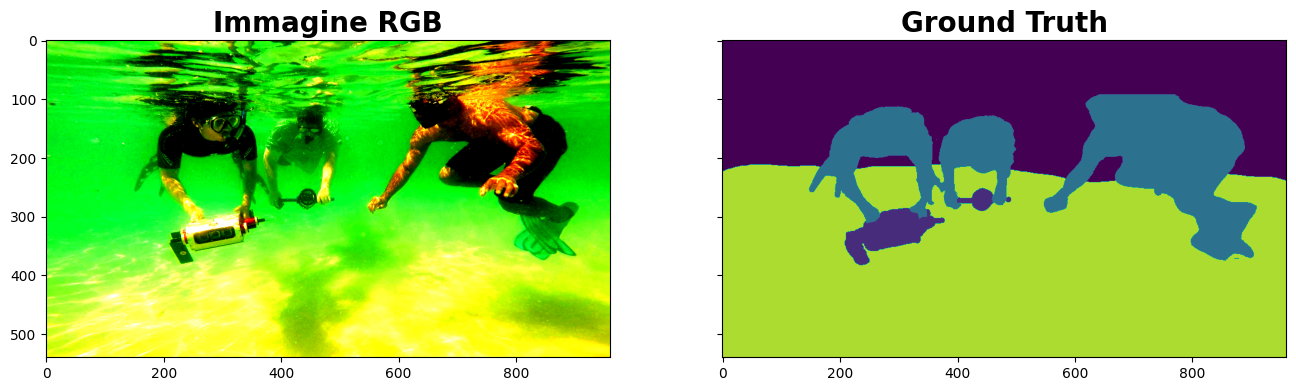

<Figure size 640x480 with 0 Axes>

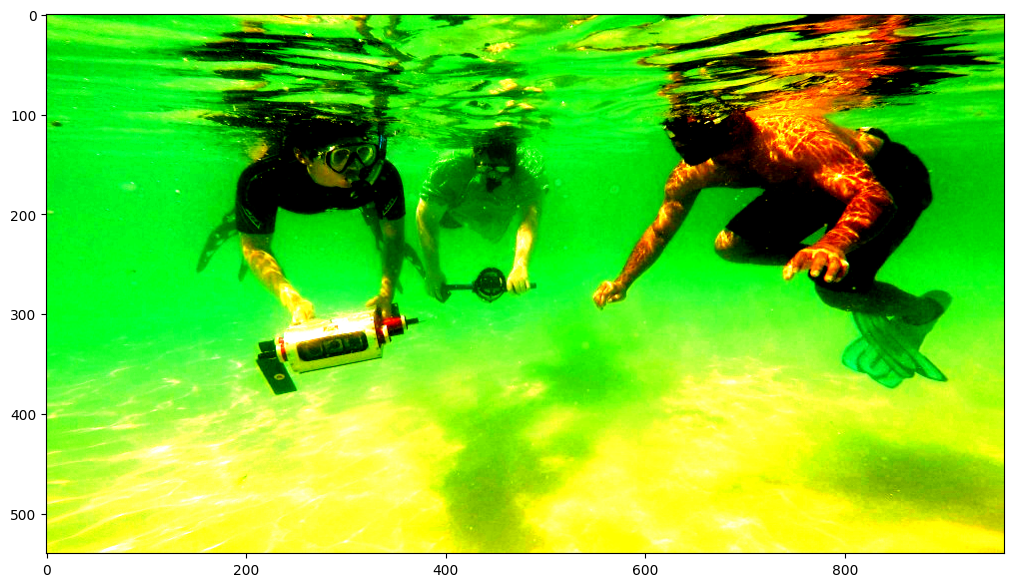

In [32]:
single_example, single_gt = train_dataset[0]

prova = np.transpose(single_example, (1, 2, 0))
#prova_gt = np.transpose(single_gt, (1, 2, 0))

print(f"Single example: {single_example.shape}, {single_gt.shape}")

for data in train_loader:
    batch_example, batch_gt = data
    break

print(f"Batch example: {batch_example.shape},{batch_gt.shape}")

plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(prova)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(single_gt, clim=[0,8])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

single_example2, single_gt2 = test_dataset[5]

prova2 = np.transpose(single_example2, (1, 2, 0))
#prova_gt = np.transpose(single_gt, (1, 2, 0))


print(f"Single example: {single_example2.shape}, {single_gt2.shape}")

plt.figure()
axs[0].imshow(prova2)
fig, ax = plt.subplots(1, 1, figsize=(16,7))  # Single subplot
ax.imshow(prova2)

axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(single_gt2, clim=[0,8])
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

In [20]:
num_classes = 8

import torch
import torch.nn as nn
import torch.nn.functional as F

class AtrousConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(AtrousConv, self).__init__()
        padding = dilation * (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous1 = AtrousConv(in_channels, out_channels, kernel_size=1, dilation=1)
        self.atrous2 = AtrousConv(in_channels, out_channels, kernel_size=3, dilation=2)
        self.atrous4 = AtrousConv(in_channels, out_channels, kernel_size=3, dilation=4)
        self.atrous8 = AtrousConv(in_channels, out_channels, kernel_size=3, dilation=8)
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.atrous1(x)
        x2 = self.atrous2(x)
        x3 = self.atrous4(x)
        x4 = self.atrous8(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x1, x2, x3, x4, x5], dim=1)
        x = self.conv1(x)
        return self.relu(self.bn(x))
        
class UNetWithASPP(nn.Module):
    def __init__(self, num_classes):
        super(UNetWithASPP, self).__init__()
        self.num_classes = num_classes
        
        # Contrattivo
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Aggiunta ASPP qui
        self.aspp = ASPP(in_channels=1024, out_channels=512)
        
        # Espansivo
        self.expansive_11 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        
        # Applicare ASPP qui
        aspp_out = self.aspp(middle_out)  # [batch_size, 512, 16, 16]
        
        expansive_11_out = self.expansive_11(aspp_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        
        return output_out
        

model = UNetWithASPP(num_classes=num_classes)

#x = torch.randn(1, 3, 256, 512)  # Example input
#output = model(x)

#print("Output shape:", output.shape)
model = model.to(device)

In [11]:
# Carica il checkpoint
checkpoint_pretrained = torch.load('/kaggle/input/u-net_aspp_19/pytorch/default/1/U-Net_ASPP_19.pth', weights_only=True)

# Rimuovi i pesi dell'output layer dal checkpoint
del checkpoint_pretrained['output.weight']
del checkpoint_pretrained['output.bias']

# Carica il checkpoint nel modello senza il layer di output
model.load_state_dict(checkpoint_pretrained, strict=False)

# Inizializza il layer di output con il numero corretto di classi (8 nel tuo caso)
model.output = nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1).to(device)

'''
# Congela i pesi della parte contrattiva e centrale (backbone)
# Supponiamo che il "backbone" sia costituito dalla parte di contrazione e dal livello centrale.
for param in model.contracting_11.parameters():
    param.requires_grad = False
for param in model.contracting_12.parameters():
    param.requires_grad = False
for param in model.contracting_21.parameters():
    param.requires_grad = False
for param in model.contracting_22.parameters():
    param.requires_grad = False
for param in model.contracting_31.parameters():
    param.requires_grad = False
for param in model.contracting_32.parameters():
    param.requires_grad = False
for param in model.contracting_41.parameters():
    param.requires_grad = False
for param in model.contracting_42.parameters():
    param.requires_grad = False
for param in model.middle.parameters():
    param.requires_grad = False

# Ora solo la parte espansiva (decodifica) e l'output layer verranno addestrati
'''

'\n# Congela i pesi della parte contrattiva e centrale (backbone)\n# Supponiamo che il "backbone" sia costituito dalla parte di contrazione e dal livello centrale.\nfor param in model.contracting_11.parameters():\n    param.requires_grad = False\nfor param in model.contracting_12.parameters():\n    param.requires_grad = False\nfor param in model.contracting_21.parameters():\n    param.requires_grad = False\nfor param in model.contracting_22.parameters():\n    param.requires_grad = False\nfor param in model.contracting_31.parameters():\n    param.requires_grad = False\nfor param in model.contracting_32.parameters():\n    param.requires_grad = False\nfor param in model.contracting_41.parameters():\n    param.requires_grad = False\nfor param in model.contracting_42.parameters():\n    param.requires_grad = False\nfor param in model.middle.parameters():\n    param.requires_grad = False\n\n# Ora solo la parte espansiva (decodifica) e l\'output layer verranno addestrati\n'

**Loss, ottimizzatore e iperparametri**

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=1.5, reduction='mean'):

        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, predictions, targets):

        # Compute the cross-entropy loss per pixel
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')

        # Convert to probabilities
        p_t = torch.exp(-ce_loss)

        # Apply the focal loss formula
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss

        # Apply the specified reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [12]:
# Definisci il numero di epoche e il learning rate

epochs = 15
#learning_rate = 0.0001

# Definire la loss function, che può essere custom o presa dal pacchetto nn

criterion = nn.CrossEntropyLoss()

# definire l'ottimizzatore
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.01, momentum=0.9, weight_decay=0.0001
)


In [13]:
#Carico il checkpoint
import json
checkpoint_path = '/kaggle/working/checkpoint.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    with open("/kaggle/working/training_history.json", "r") as f:
        history = json.load(f)
    step_losses = history['step_losses']
    epoch_losses = history['epoch_losses']
    step_losses_val = history['step_losses_val']
    epoch_losses_val = history['epoch_losses_val']
    min_loss = checkpoint['loss']
    max_jaccard = checkpoint['jaccard']
    print(f"Checkpoint caricato: riprendo da epoch {start_epoch}")
    
except FileNotFoundError:
    checkpoint = None
    start_epoch = 0
    step_losses = []
    epoch_losses = []
    epoch_jaccards = []
    step_jaccard = []
    
    step_losses_val = []
    epoch_losses_val = []
    epoch_jaccards_val = []
    step_jaccard_val = []
    min_loss = np.inf
    max_jaccard = -np.inf  # Inizializzato a un valore minimo
    print("Checkpoint non trovato, inizio addestramento da zero.")

Checkpoint non trovato, inizio addestramento da zero.


In [14]:
from torchmetrics import JaccardIndex

metric = JaccardIndex(task='multiclass', num_classes=num_classes).to(device)

# Training

In [15]:
import time
import json
from tqdm import tqdm

epoch_jaccards = []
step_jaccard = []
epoch_jaccards_val = []
step_jaccard_val = []

fit_time = time.time()

for epoch in range(epochs):
    since = time.time()
    epoch_loss = 0
    epoch_loss_val = 0
    epoch_jaccard = 0
    epoch_jaccard_val = 0
    first_batch = True  # Flag per il primo batch

    model.train()
    print(f"Epoch {epoch + 1}/{epochs}")
    with tqdm(total=len(train_loader), desc="Training") as pbar_train:  # Barra di progresso per il training
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            with torch.no_grad():
                jaccard = metric(Y_pred, Y)

            if epoch == 0 and first_batch:
                print(f"Prima loss: {loss.item()}")
                first_batch = False  # Aggiorna il flag

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_jaccard += jaccard.item()
            step_jaccard.append(jaccard.item())
            step_losses.append(loss.item())
            
            # Aggiorna la barra di progresso
            pbar_train.update(1)
            pbar_train.set_postfix({"Loss": loss.item(), "Jaccard": jaccard.item()})

    epoch_losses.append(epoch_loss / len(train_loader))
    epoch_jaccards.append(epoch_jaccard / len(train_loader))

    model.eval()
    with tqdm(total=len(val_loader), desc="Validation") as pbar_val:  # Barra di progresso per la validazione
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                Y_pred = model(X)
                loss = criterion(Y_pred, Y)
                epoch_loss_val += loss.item()
                step_losses_val.append(loss.item())

                jaccard_val = metric(Y_pred, Y)
                epoch_jaccard_val += jaccard_val.item()
                step_jaccard_val.append(jaccard_val.item())
                
                # Aggiorna la barra di progresso
                pbar_val.update(1)
                pbar_val.set_postfix({"Val Loss": loss.item(), "Val Jaccard": jaccard_val.item()})
        
    epoch_losses_val.append(epoch_loss_val / len(val_loader))
    epoch_jaccards_val.append(epoch_jaccard_val / len(val_loader))
        
    print("Epoch:{}/{}  ".format(start_epoch + epoch + 1, start_epoch + epochs),
          "Train Loss: {:.5f}  ".format(epoch_loss / len(train_loader)),
          "Val Loss: {:.5f}  ".format(epoch_loss_val / len(val_loader)),
          "Jaccard Train {:.5f}  ".format(epoch_jaccard / len(train_loader)),
          "Jaccard Val  {:.5f}  ".format(epoch_jaccard_val / len(val_loader)),
          "Time: {:.2f}m".format((time.time() - since) / 60))
    
    if ((epoch_loss_val / len(val_loader)) < min_loss):
        print('Checkpoint aggiornato:')
        print(f"Val Loss: {min_loss:.3f} -> {epoch_loss_val / len(val_loader):.3f}")
        print(f"Jaccard: {max_jaccard:.3f} -> {epoch_jaccard_val / len(val_loader):.3f}")
        min_loss = epoch_loss_val / len(val_loader)
        max_jaccard = epoch_jaccard_val / len(val_loader)
    
        print('Salvataggio del modello...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': start_epoch + epoch + 1,
            'loss': min_loss,
            'jaccard': max_jaccard,
        }, 'checkpoint.pth')

    # Aggiorna la history
    history = {
        'epoch_losses': epoch_losses,
        'epoch_losses_val': epoch_losses_val,
        'step_losses': step_losses,
        'step_losses_val': step_losses_val,
        'epoch_jaccards': epoch_jaccards,
        'epoch_jaccards_val': epoch_jaccards_val,
        'step_jaccard': step_jaccard,
        'step_jaccard_val': step_jaccard_val,
    }

    # Salva la history ad ogni epoca
    with open('training_history.json', 'w') as f:
        json.dump(history, f)

print('Total time: {:.2f} m' .format((time.time() - fit_time) / 60))

Epoch 1/15


Training:   0%|          | 0/172 [00:00<?, ?it/s]

Prima loss: 2.1224820613861084


Validation: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s, Val Loss=1.55, Val Jaccard=0.139] 


Epoch:1/15   Train Loss: 1.59104   Val Loss: 1.29125   Jaccard Train 0.14589   Jaccard Val  0.15665   Time: 3.35m
Checkpoint aggiornato:
Val Loss: inf -> 1.291
Jaccard: -inf -> 0.157
Salvataggio del modello...
Epoch 2/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.29it/s, Val Loss=1.42, Val Jaccard=0.138] 


Epoch:2/15   Train Loss: 1.39606   Val Loss: 1.28973   Jaccard Train 0.16970   Jaccard Val  0.18791   Time: 2.99m
Checkpoint aggiornato:
Val Loss: 1.291 -> 1.290
Jaccard: 0.157 -> 0.188
Salvataggio del modello...
Epoch 3/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.29it/s, Val Loss=1.52, Val Jaccard=0.128] 


Epoch:3/15   Train Loss: 1.34758   Val Loss: 1.18285   Jaccard Train 0.18099   Jaccard Val  0.21249   Time: 3.00m
Checkpoint aggiornato:
Val Loss: 1.290 -> 1.183
Jaccard: 0.188 -> 0.212
Salvataggio del modello...
Epoch 4/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.29it/s, Val Loss=1.5, Val Jaccard=0.13]   


Epoch:4/15   Train Loss: 1.27109   Val Loss: 1.17957   Jaccard Train 0.19726   Jaccard Val  0.18693   Time: 3.00m
Checkpoint aggiornato:
Val Loss: 1.183 -> 1.180
Jaccard: 0.212 -> 0.187
Salvataggio del modello...
Epoch 5/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s, Val Loss=1.45, Val Jaccard=0.175] 


Epoch:5/15   Train Loss: 1.23462   Val Loss: 1.06447   Jaccard Train 0.20780   Jaccard Val  0.21271   Time: 2.99m
Checkpoint aggiornato:
Val Loss: 1.180 -> 1.064
Jaccard: 0.187 -> 0.213
Salvataggio del modello...
Epoch 6/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.29it/s, Val Loss=1.88, Val Jaccard=0.148] 


Epoch:6/15   Train Loss: 1.19816   Val Loss: 1.03757   Jaccard Train 0.22390   Jaccard Val  0.23424   Time: 3.00m
Checkpoint aggiornato:
Val Loss: 1.064 -> 1.038
Jaccard: 0.213 -> 0.234
Salvataggio del modello...
Epoch 7/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.31it/s, Val Loss=1.44, Val Jaccard=0.165] 


Epoch:7/15   Train Loss: 1.14275   Val Loss: 1.01496   Jaccard Train 0.24477   Jaccard Val  0.24381   Time: 2.97m
Checkpoint aggiornato:
Val Loss: 1.038 -> 1.015
Jaccard: 0.234 -> 0.244
Salvataggio del modello...
Epoch 8/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s, Val Loss=1.51, Val Jaccard=0.134] 


Epoch:8/15   Train Loss: 1.13001   Val Loss: 1.00076   Jaccard Train 0.24936   Jaccard Val  0.25038   Time: 2.97m
Checkpoint aggiornato:
Val Loss: 1.015 -> 1.001
Jaccard: 0.244 -> 0.250
Salvataggio del modello...
Epoch 9/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s, Val Loss=1.5, Val Jaccard=0.152]  


Epoch:9/15   Train Loss: 1.12084   Val Loss: 0.97088   Jaccard Train 0.25680   Jaccard Val  0.26491   Time: 2.98m
Checkpoint aggiornato:
Val Loss: 1.001 -> 0.971
Jaccard: 0.250 -> 0.265
Salvataggio del modello...
Epoch 10/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s, Val Loss=1.41, Val Jaccard=0.207] 


Epoch:10/15   Train Loss: 1.09976   Val Loss: 0.98794   Jaccard Train 0.25698   Jaccard Val  0.25697   Time: 2.97m
Epoch 11/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s, Val Loss=1.63, Val Jaccard=0.175] 


Epoch:11/15   Train Loss: 1.08142   Val Loss: 0.96596   Jaccard Train 0.26581   Jaccard Val  0.24932   Time: 2.97m
Checkpoint aggiornato:
Val Loss: 0.971 -> 0.966
Jaccard: 0.265 -> 0.249
Salvataggio del modello...
Epoch 12/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s, Val Loss=1.42, Val Jaccard=0.206] 


Epoch:12/15   Train Loss: 1.06040   Val Loss: 0.96541   Jaccard Train 0.27761   Jaccard Val  0.26487   Time: 2.97m
Checkpoint aggiornato:
Val Loss: 0.966 -> 0.965
Jaccard: 0.249 -> 0.265
Salvataggio del modello...
Epoch 13/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s, Val Loss=1.67, Val Jaccard=0.212] 


Epoch:13/15   Train Loss: 1.04856   Val Loss: 0.92771   Jaccard Train 0.29000   Jaccard Val  0.27285   Time: 2.97m
Checkpoint aggiornato:
Val Loss: 0.965 -> 0.928
Jaccard: 0.265 -> 0.273
Salvataggio del modello...
Epoch 14/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s, Val Loss=1.38, Val Jaccard=0.187] 


Epoch:14/15   Train Loss: 1.04672   Val Loss: 0.92901   Jaccard Train 0.28441   Jaccard Val  0.28230   Time: 2.98m
Epoch 15/15


Validation: 100%|██████████| 19/19 [00:14<00:00,  1.29it/s, Val Loss=1.46, Val Jaccard=0.18]  

Epoch:15/15   Train Loss: 1.03392   Val Loss: 0.95348   Jaccard Train 0.28805   Jaccard Val  0.27123   Time: 2.97m
Total time: 45.26 m


In [ ]:
# Carica la history dal file JSON
with open('training_history.json', 'r') as f:
    history = json.load(f)


fig = plt.figure()
plt.plot(history['epoch_losses'], color='blue')
plt.plot(history['epoch_losses_val'], color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy loss')


**Check model predictions**

In [20]:
value_to_color = {v: k for k, v in color_to_value.items()}

# Funzione di trasformazione inversa
def convert_array_to_mask(mask_array, value_to_color):
    new_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)
    for value, color in value_to_color.items():
        new_mask[mask_array == value] = color
    return new_mask

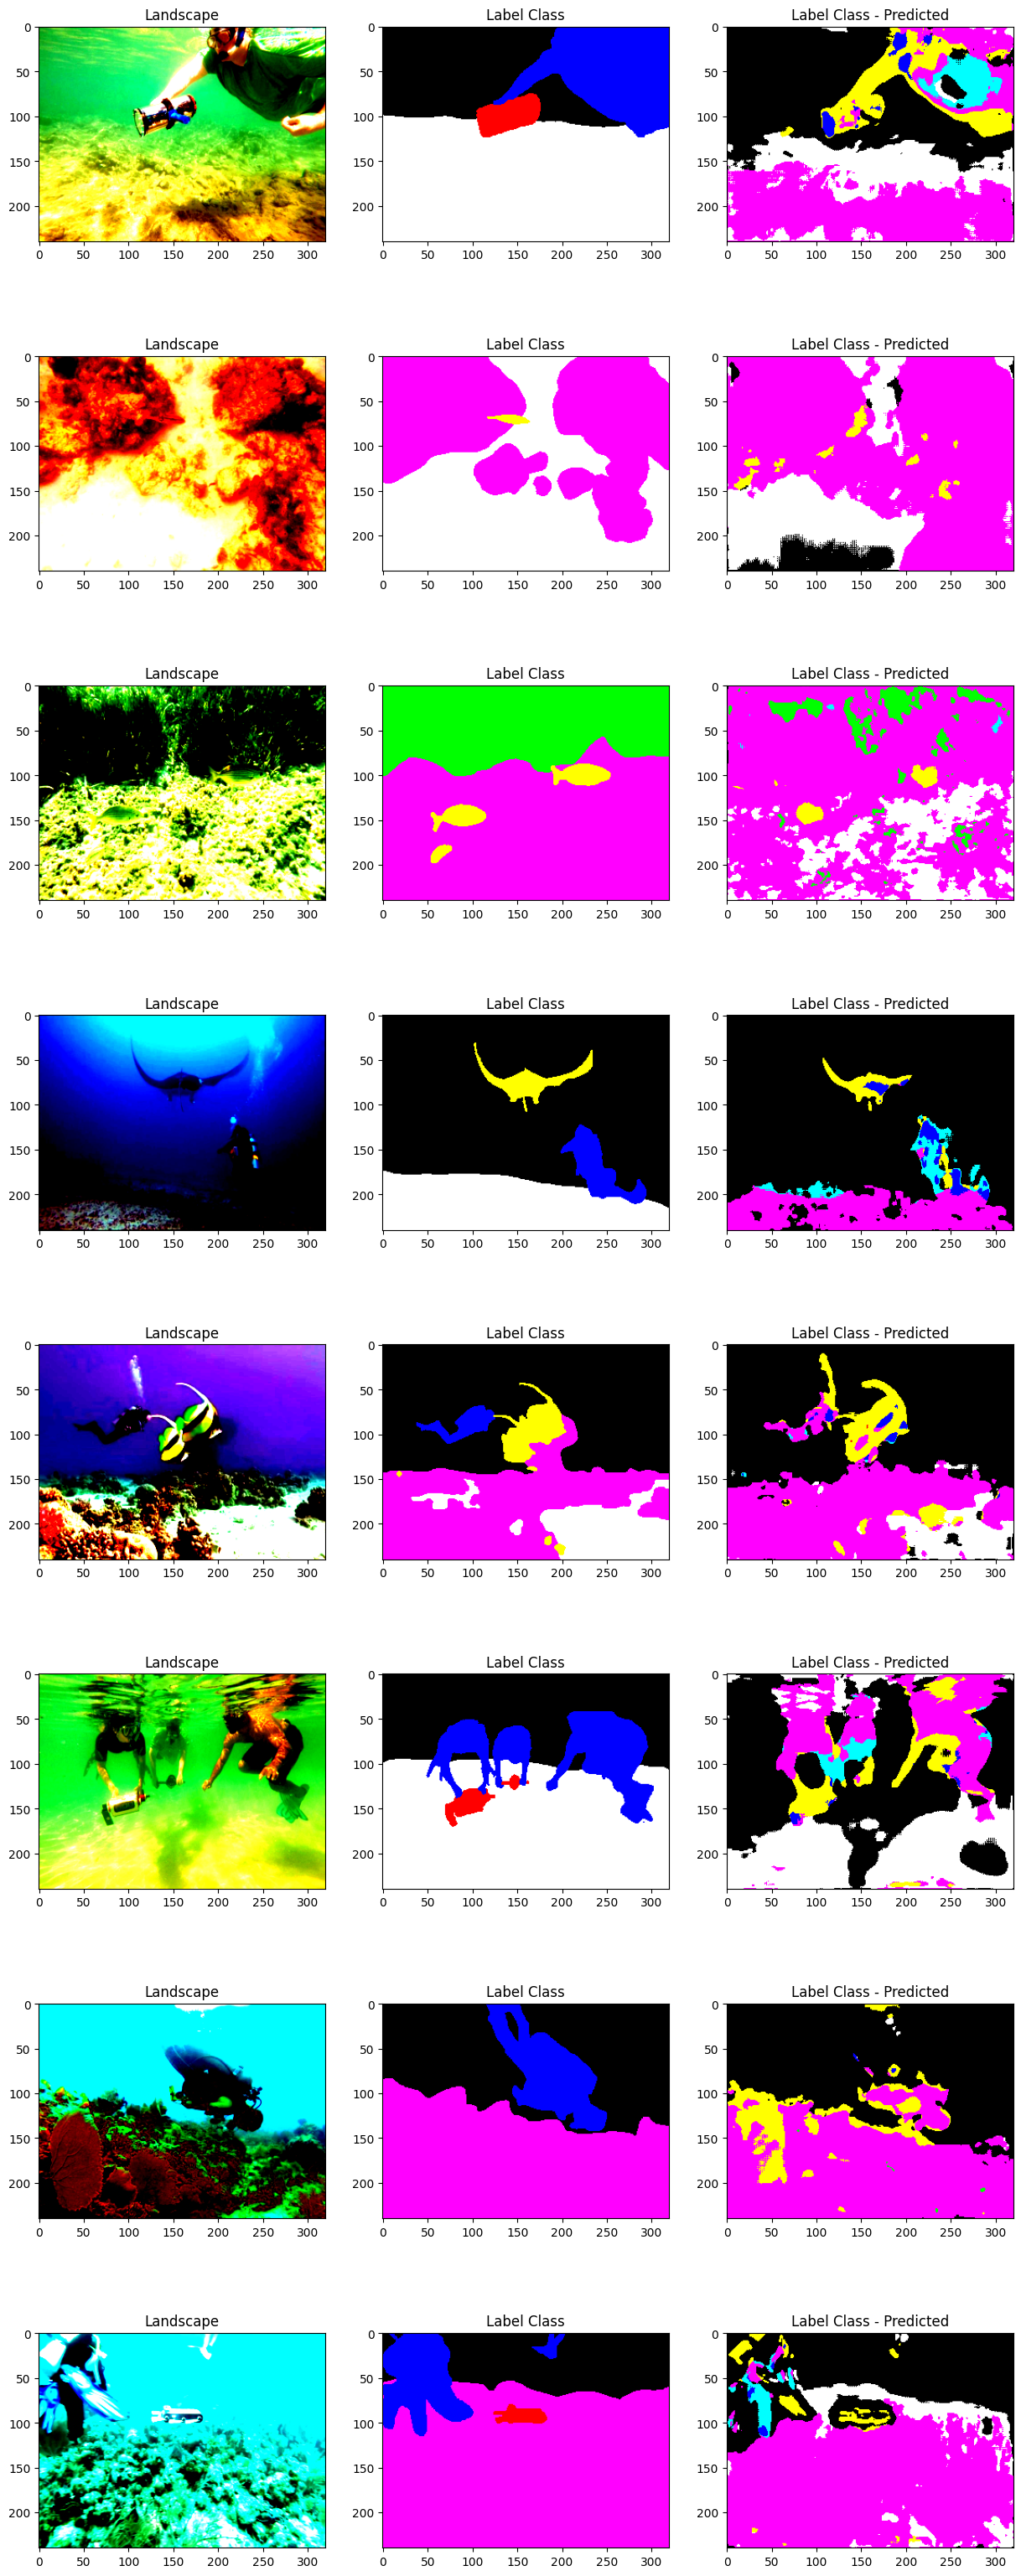

In [21]:
'''
inverse_transform = T.Compose([
    T.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], 
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
])

inverse_transform = T.Compose([
    T.Normalize(
        mean=(-0.28881703 / 0.18679116, -0.32694227 / 0.18973092, -0.28622528 / 0.18646142),
        std=(1 / 0.18679116, 1 / 0.18973092, 1 / 0.18646142)
    )
])
'''

checkpoint_path = '/kaggle/working/checkpoint.pth'

checkpoint = torch.load(checkpoint_path,  weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

X, Y = next(iter(test_dataloader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
Y_pred = torch.argmax(Y_pred, dim=1)

test_batch_size = (len(X))

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))
    
for i in range (test_batch_size):
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    label_class = convert_array_to_mask(label_class, value_to_color)
    label_class_predicted = convert_array_to_mask(label_class_predicted, value_to_color)

    # Plot
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, clim=[0,8])
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, clim=[0,8])
    axes[i, 2].set_title("Label Class - Predicted")

Top 1 IoU: 0.47549372911453247


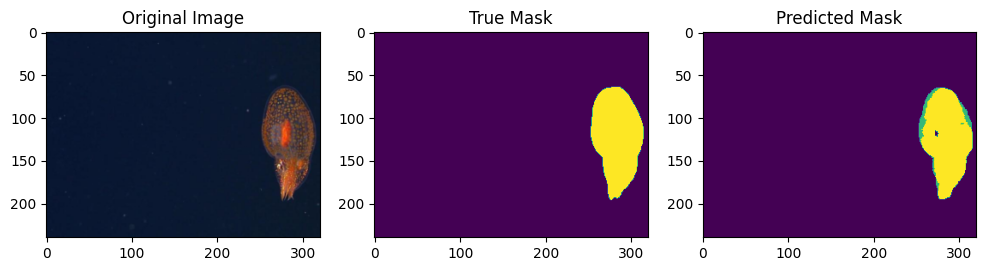

Top 2 IoU: 0.47549372911453247


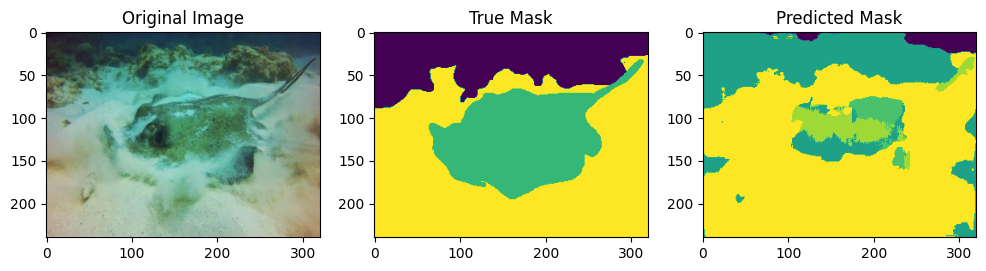

Top 3 IoU: 0.47549372911453247


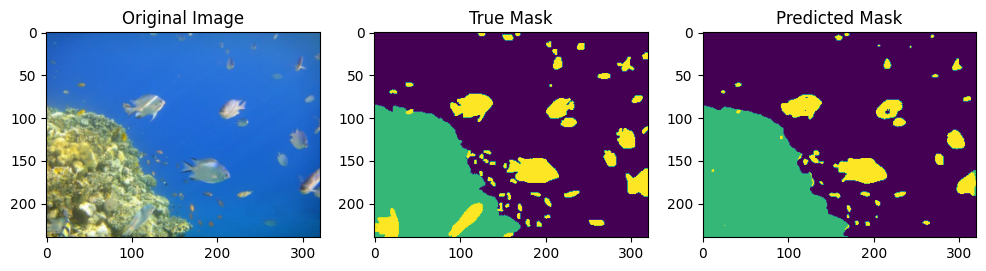

Top 4 IoU: 0.47549372911453247


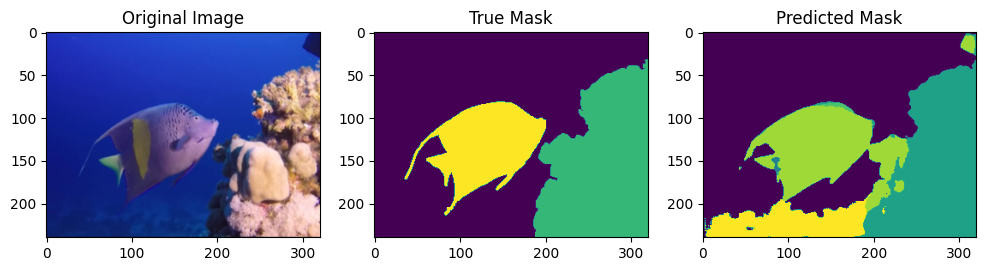

Top 5 IoU: 0.47549372911453247


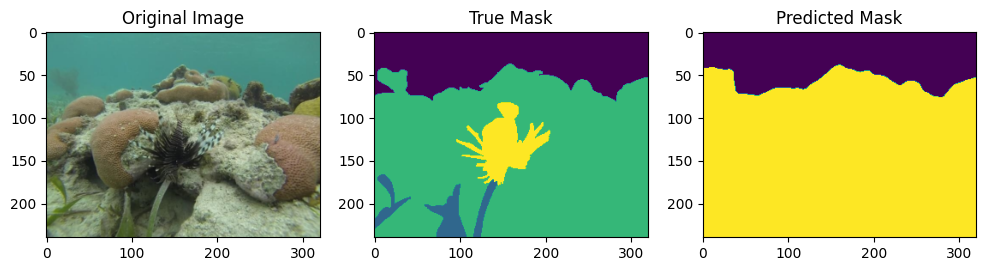

Top 6 IoU: 0.47549372911453247


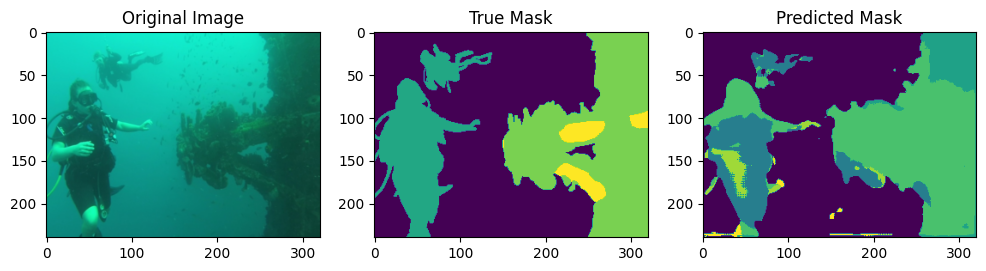

Top 7 IoU: 0.47549372911453247


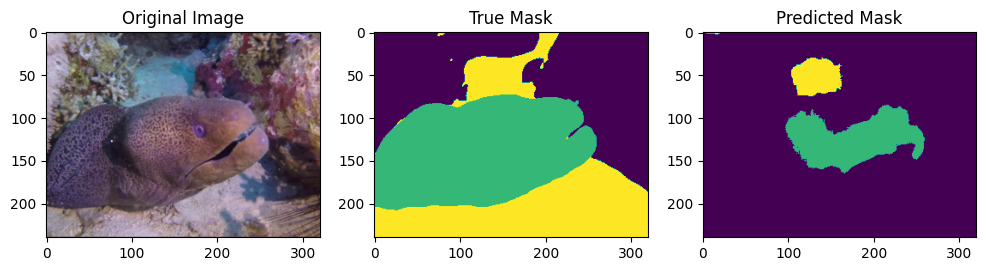

Top 8 IoU: 0.47549372911453247


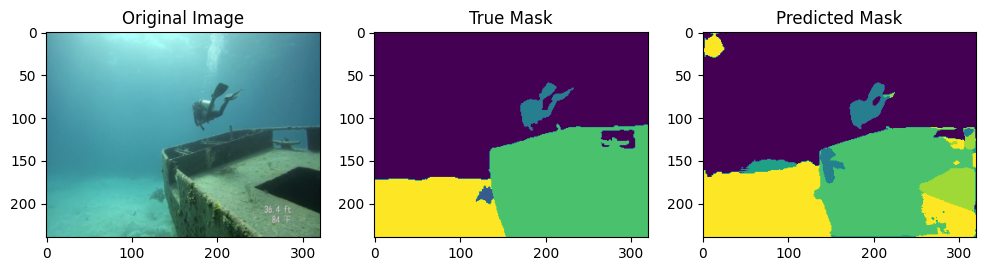

Top 9 IoU: 0.40043795108795166


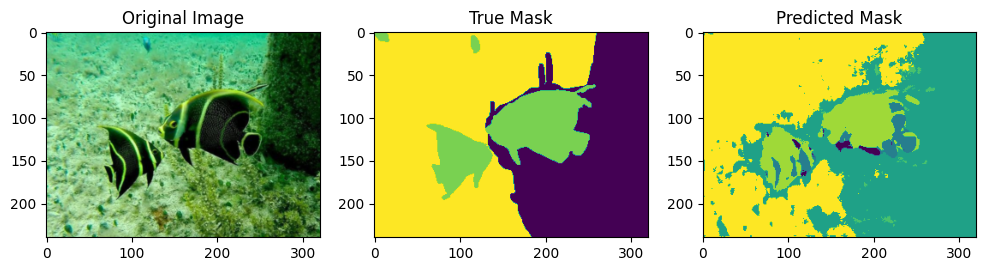

Top 10 IoU: 0.40043795108795166


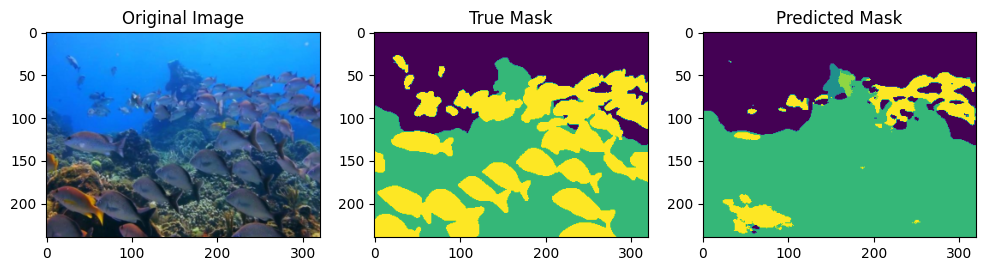

In [18]:
# Inizializza una lista per salvare le predizioni e le metriche
top_predictions = []

jaccard = JaccardIndex(task='multiclass', num_classes=num_classes)

for X, Y in test_dataloader:
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    Y_pred = torch.argmax(Y_pred, dim=1)

    iou = jaccard(Y_pred.cpu(), Y.cpu()).item()
    
    # Aggiungi l'IoU e le immagini originali/predette alla lista
    for i in range(X.size(0)):  # Itera su ogni immagine nel batch
        top_predictions.append({
            "iou": iou,
            "true": Y[i].cpu().detach().numpy(),
            "predicted": Y_pred[i].cpu().detach().numpy(),
            "image": X[i].cpu().detach().numpy()
        })

# Ordina le predizioni in base all'IoU
top_predictions = sorted(top_predictions, key=lambda x: x["iou"], reverse=True)

# Prendi le 10 migliori predizioni
top_10_predictions = top_predictions[:10]

# Stampa e visualizza le predizioni migliori
for idx, item in enumerate(top_10_predictions):
    print(f"Top {idx+1} IoU: {item['iou']}")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(item["image"].transpose(1, 2, 0))  # Assumi che l'immagine sia in formato CHW
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(item["true"])
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(item["predicted"])
    plt.title("Predicted Mask")
    
    plt.show()


**Funzione di labeling**

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_cityscapes_prediction(image, prediction, num_classes):
    """
    Visualizza l'immagine originale accanto alla maschera colorata basata sulla predizione,
    usando i primi 8 colori della colormap tab10 per ciascuna classe.

    Args:
        image (numpy.ndarray or torch.Tensor): Immagine originale (HxWx3).
        prediction (numpy.ndarray or torch.Tensor): Label predetta (HxW).
        num_classes (int): Numero totale di classi.
    """
    # Se l'immagine è un tensore, convertila in numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().detach().numpy()  # Cambia dimensioni da (C, H, W) a (H, W, C)

    # Se la predizione è un tensore, convertila in numpy
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().detach().numpy()

    # Assicuriamoci che l'immagine sia in formato uint8
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Ottieni i primi 8 colori dalla colormap tab10
    cmap = plt.get_cmap('tab10', num_classes)  # Colormap tab10 con 8 colori
    class_colors = [tuple((np.array(cmap(i)) * 255).astype(np.uint8)[:3]) for i in range(num_classes)]

    # Creiamo una maschera colorata basata sulla predizione
    mask = np.zeros_like(image, dtype=np.uint8)
    for class_id, color in enumerate(class_colors):
        mask[prediction == class_id] = color

    # Sovrapponi la maschera sull'immagine originale
    overlay = (0.5 * image + 0.5 * mask).astype(np.uint8)

    # Trova le classi presenti nella predizione
    unique_classes = np.unique(prediction)
    
    # Recupera i nomi delle classi presenti
    unique_names = [class_dict.get(class_id, 'Non trovato') for class_id in unique_classes]

    # Plot dell'immagine e della maschera
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(image)
    axes[0].set_title("Immagine Originale")
    axes[0].axis('off')

    axes[1].imshow(overlay)
    axes[1].set_title("Predizione Sovrapposta")
    axes[1].axis('off')

    # Crea una legenda con le classi presenti
    unique_colors = [class_colors[class_id] for class_id in unique_classes]
    handles = [plt.Rectangle((0, 0), 1, 1, color=np.array(color)/255) for color in unique_colors]
    plt.legend(handles, unique_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()


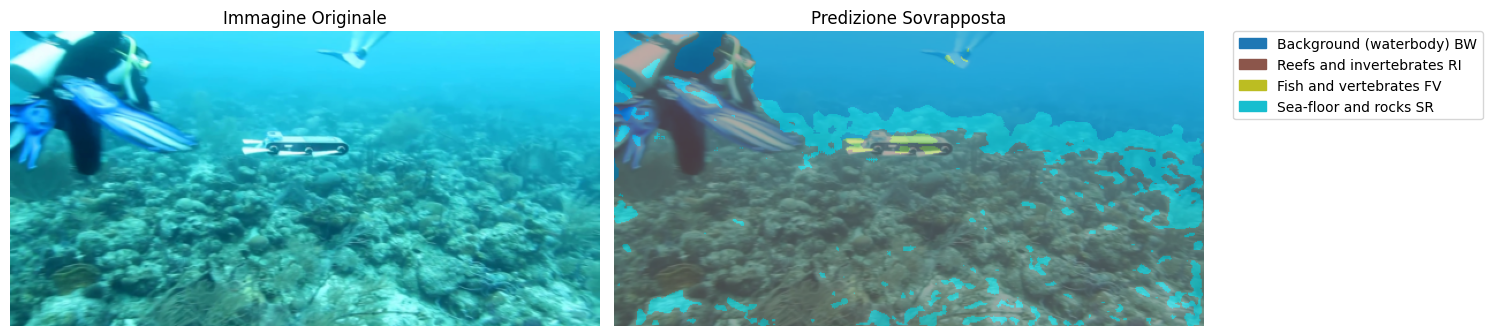

In [19]:
visualize_cityscapes_prediction(landscape, label_class_predicted, num_classes)

# Test

Mean IoU macro: 0.3581106375370707
Mean IoU micro: 0.6209167242050171
Mean IoU weighted: 0.6423935315438679


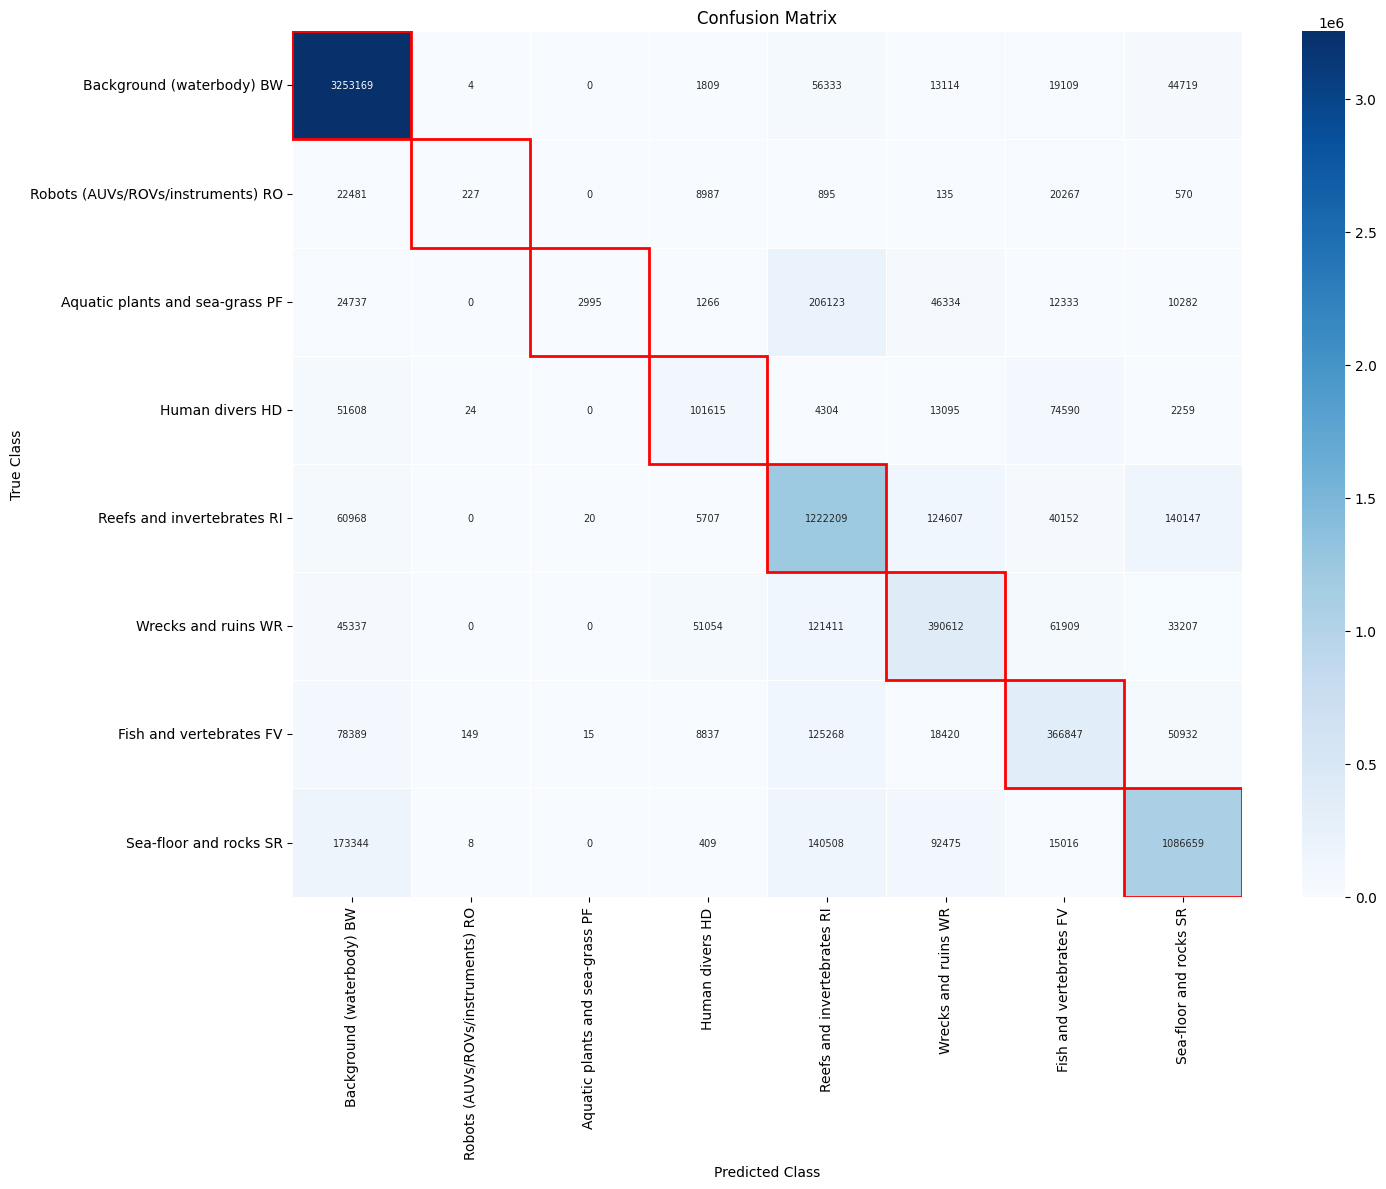

In [21]:
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix
import seaborn as sns

iou_scores = []
iou_scores_micro = []
iou_scores_weighted = []

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # Matrice di confusione inizializzata

jaccard = JaccardIndex(task='multiclass', num_classes=num_classes)
jaccard_micro = JaccardIndex(task='multiclass', average='micro', num_classes=num_classes)
jaccard_weighted = JaccardIndex(task='multiclass', average='weighted', num_classes=num_classes)

for X,Y in test_dataloader:

    X,Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    Y_pred = torch.argmax(Y_pred, dim=1)

    label_class = Y.cpu().detach().numpy()
    label_class_predicted = Y_pred.cpu().detach().numpy()
    

    iou_micro = jaccard_micro(Y_pred.cpu(), Y.cpu()).item()
    iou_weighted = jaccard_weighted(Y_pred.cpu(), Y.cpu()).item()
    iou = jaccard(Y_pred.cpu(), Y.cpu()).item()
    #print(iou)
    iou_scores.append(iou)
    iou_scores_micro.append(iou_micro)
    iou_scores_weighted.append(iou_weighted)

    # Aggiorna la matrice di confusione per l'immagine corrente
    conf_matrix += confusion_matrix(
        label_class.flatten(), 
        label_class_predicted.flatten(), 
        labels=np.arange(num_classes),  # Assicura che tutte le classi siano considerate
    )
    
# Plot della matrice di confusione
plt.figure(figsize=(15, 12))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt="d", 
    xticklabels=[class_dict.get(cls, str(cls)) for cls in class_dict],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in class_dict],
    cmap="Blues", 
    linewidths=0.5
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

# Media complessiva dell'IoU
print("Mean IoU macro:", np.mean(iou_scores))
print("Mean IoU micro:", np.mean(iou_scores_micro))
print("Mean IoU weighted:", np.mean(iou_scores_weighted))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()

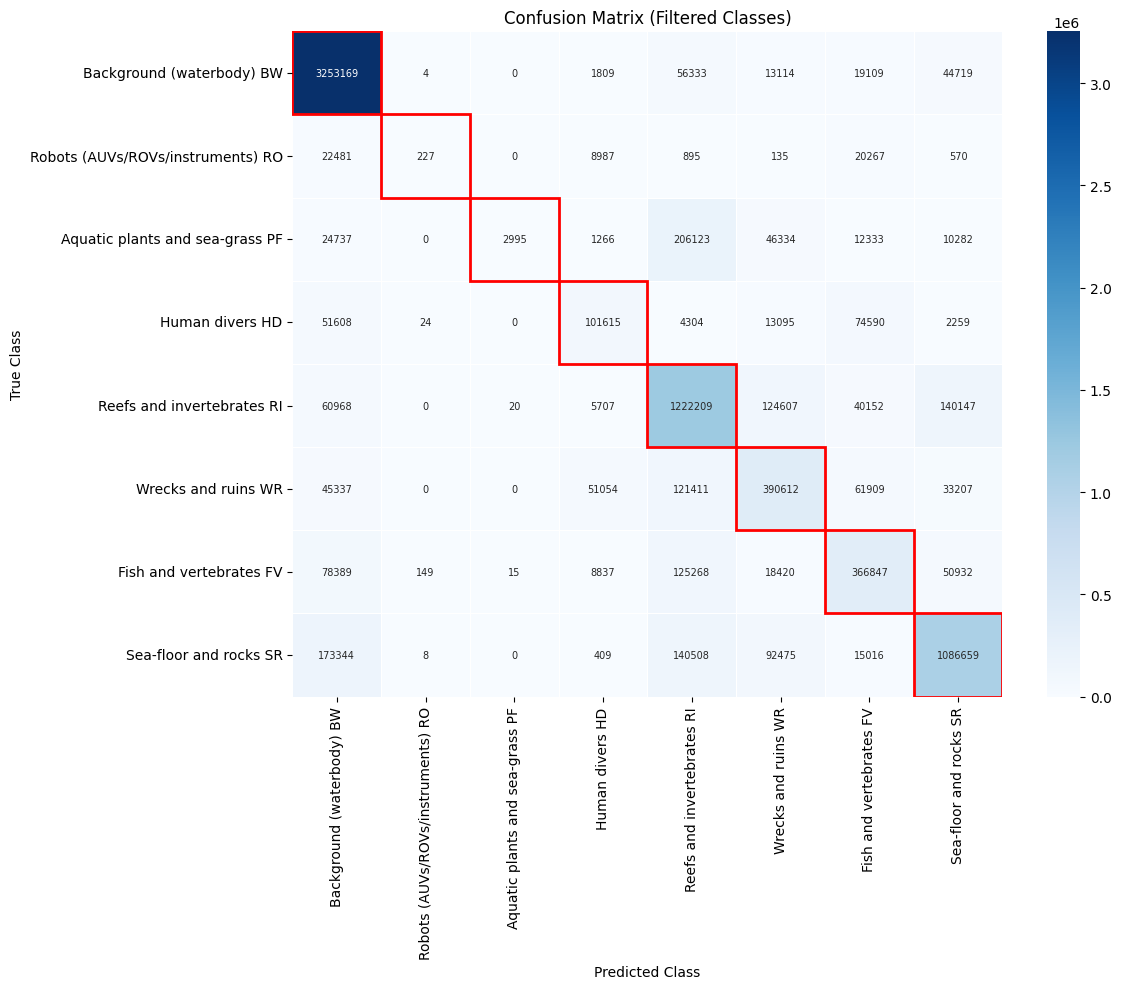

In [22]:
# Calcola la somma dei pixel per classe nella ground truth
class_frequencies = conf_matrix.sum(axis=1)

# Filtra solo le classi con almeno un certo numero di pixel
threshold = 100  # Cambia il valore a seconda delle tue esigenze
dominant_classes = [cls for cls, freq in enumerate(class_frequencies) if freq > threshold]

# Genera una matrice ridotta
conf_matrix_reduced = conf_matrix[np.ix_(dominant_classes, dominant_classes)]

# Visualizza la matrice ridotta
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_reduced, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt="d",
    xticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    cmap="Blues",
    linewidths=0.5
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Filtered Classes)")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()

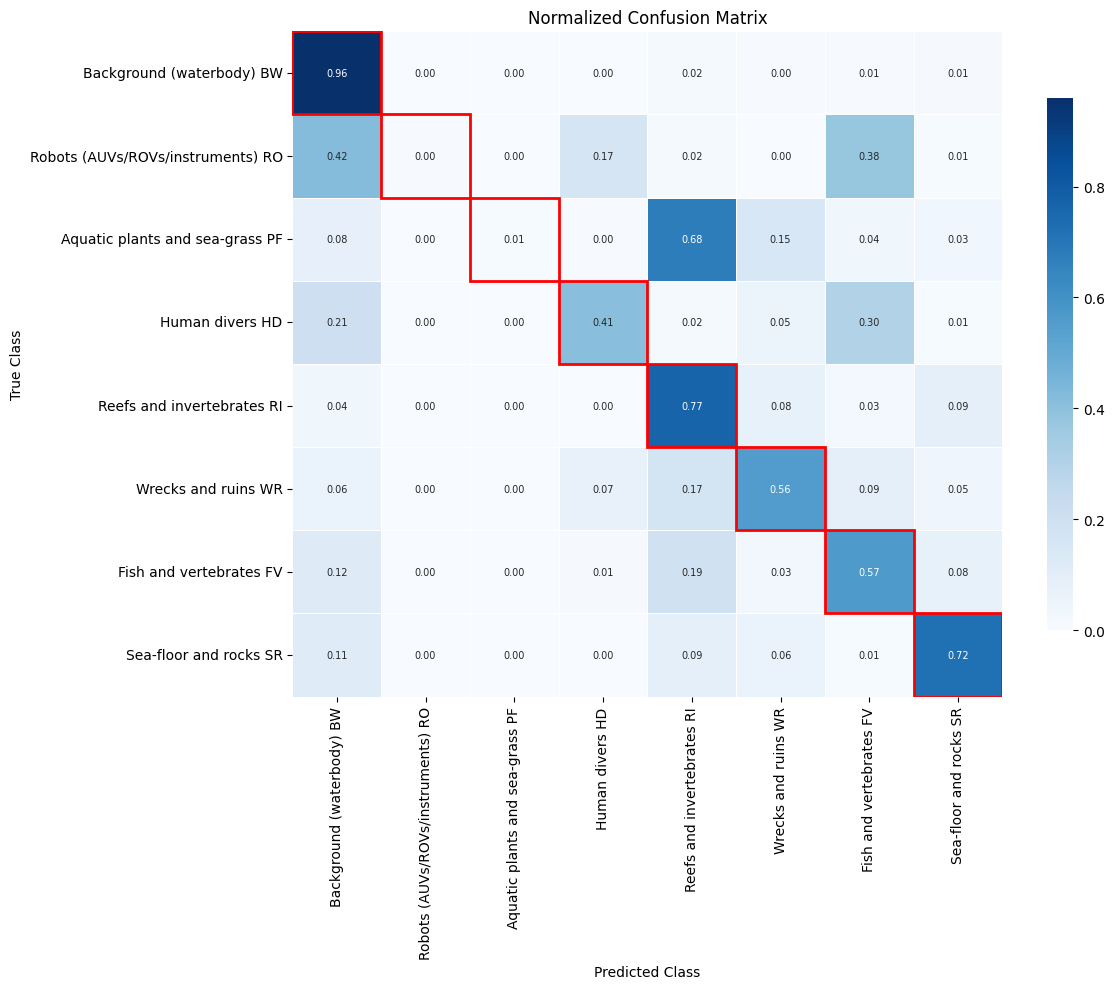

In [23]:
# Normalizzazione per riga (valori percentuali), con gestione righe vuote
row_sums = conf_matrix_reduced.sum(axis=1, keepdims=True)
conf_matrix_normalized = np.divide(
    conf_matrix_reduced, 
    row_sums, 
    where=row_sums != 0  # Esegui la divisione solo se la somma della riga è diversa da zero
)

# Sostituisci eventuali NaN con 0 (righe con somma zero)
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)

# Trova i valori minimo e massimo della matrice normalizzata per regolare la colorbar
vmin = conf_matrix_normalized.min()
vmax = conf_matrix_normalized.max()

plt.figure(figsize=(12, 10))

# Crea la heatmap
sns.heatmap(
    conf_matrix_normalized, 
    annot=True, 
    annot_kws={"size": 7},  # Dimensione del testo
    fmt=".2f",
    xticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    yticklabels=[class_dict.get(cls, str(cls)) for cls in dominant_classes],
    cmap="Blues",  # Colormap
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},  # Aggiusta la dimensione della colorbar
    vmin=vmin,  # Imposta il minimo della colorbar
    vmax=vmax   # Imposta il massimo della colorbar
)

ax = plt.gca()
for i in range(conf_matrix.shape[0]):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()  # Adatta automaticamente il layout
plt.show()


In [24]:
from tabulate import tabulate

# Precision: true positives / (true positives + false positives)
precision = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=0), 1)

# Recall: true positives / (true positives + false negatives)
recall = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=1), 1)

# F1-score: harmonic mean of precision and recall (senza warning)
f1_score = np.zeros_like(precision)
valid_mask = (precision + recall) > 0
f1_score[valid_mask] = 2 * (precision[valid_mask] * recall[valid_mask]) / (precision[valid_mask] + recall[valid_mask])

# Metriche globali
micro_precision = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
micro_recall = micro_precision  # Uguale per il micro average
micro_f1 = micro_precision  # Uguale per il micro average

macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1_score)

# Costruzione della tabella delle classi
table_data = []
for cls in range(num_classes):
    class_name = class_dict.get(cls, f"Class {cls}")
    pred_count = conf_matrix.sum(axis=0)[cls]  # Previsioni per questa classe
    true_count = conf_matrix.sum(axis=1)[cls]  # Veri esempi per questa classe

    if true_count == 0 and pred_count == 0:
        # Classe completamente assente nel dataset di test
        table_data.append([class_name, "-", "-", "-", "Absent in test set"])
    elif true_count == 0:
        # Classe non presente nel dataset di test (nessun vero esempio)
        table_data.append([class_name, "-", "No true instances", "-", "No true instances"])
    elif pred_count == 0:
        # Classe mai predetta
        table_data.append([class_name, "No predictions", "-", "-", "Never predicted"])
    elif f1_score[cls] == 0:
        # Classe con tutte le predizioni sbagliate
        table_data.append([
            class_name,
            f"{precision[cls]:.2f}",
            f"{recall[cls]:.2f}",
            f"{f1_score[cls]:.2f}",
            "All predictions incorrect"
        ])
    else:
        # Classe valida con metriche calcolabili
        table_data.append([
            class_name,
            f"{precision[cls]:.2f}",
            f"{recall[cls]:.2f}",
            f"{f1_score[cls]:.2f}",
            "OK"
        ])

# Tabella delle metriche globali
global_metrics = [
    ["Micro Precision", f"{micro_precision:.2f}"],
    ["Micro Recall", f"{micro_recall:.2f}"],
    ["Micro F1-score", f"{micro_f1:.2f}"],
    ["Macro Precision", f"{macro_precision:.2f}"],
    ["Macro Recall", f"{macro_recall:.2f}"],
    ["Macro F1-score", f"{macro_f1:.2f}"]
]

# Stampa delle tabelle
print("Class-wise metrics:")
print(tabulate(
    table_data,
    headers=["Class", "Precision", "Recall", "F1-score", "Status"],
    tablefmt="grid"
))

print("\nGlobal metrics:")
print(tabulate(global_metrics, headers=["Metric", "Value"], tablefmt="grid"))


Class-wise metrics:
+-----------------------------------+-------------+----------+------------+----------+
| Class                             |   Precision |   Recall |   F1-score | Status   |
+===================================+=============+==========+============+==========+
| Background (waterbody) BW         |        0.88 |     0.96 |       0.92 | OK       |
+-----------------------------------+-------------+----------+------------+----------+
| Robots (AUVs/ROVs/instruments) RO |        0.55 |     0    |       0.01 | OK       |
+-----------------------------------+-------------+----------+------------+----------+
| Aquatic plants and sea-grass PF   |        0.99 |     0.01 |       0.02 | OK       |
+-----------------------------------+-------------+----------+------------+----------+
| Human divers HD                   |        0.57 |     0.41 |       0.48 | OK       |
+-----------------------------------+-------------+----------+------------+----------+
| Reefs and invertebrat

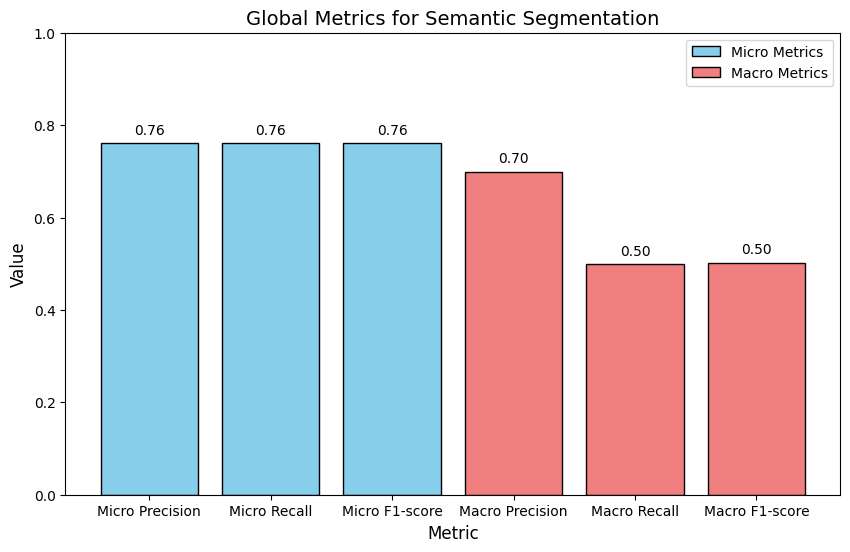

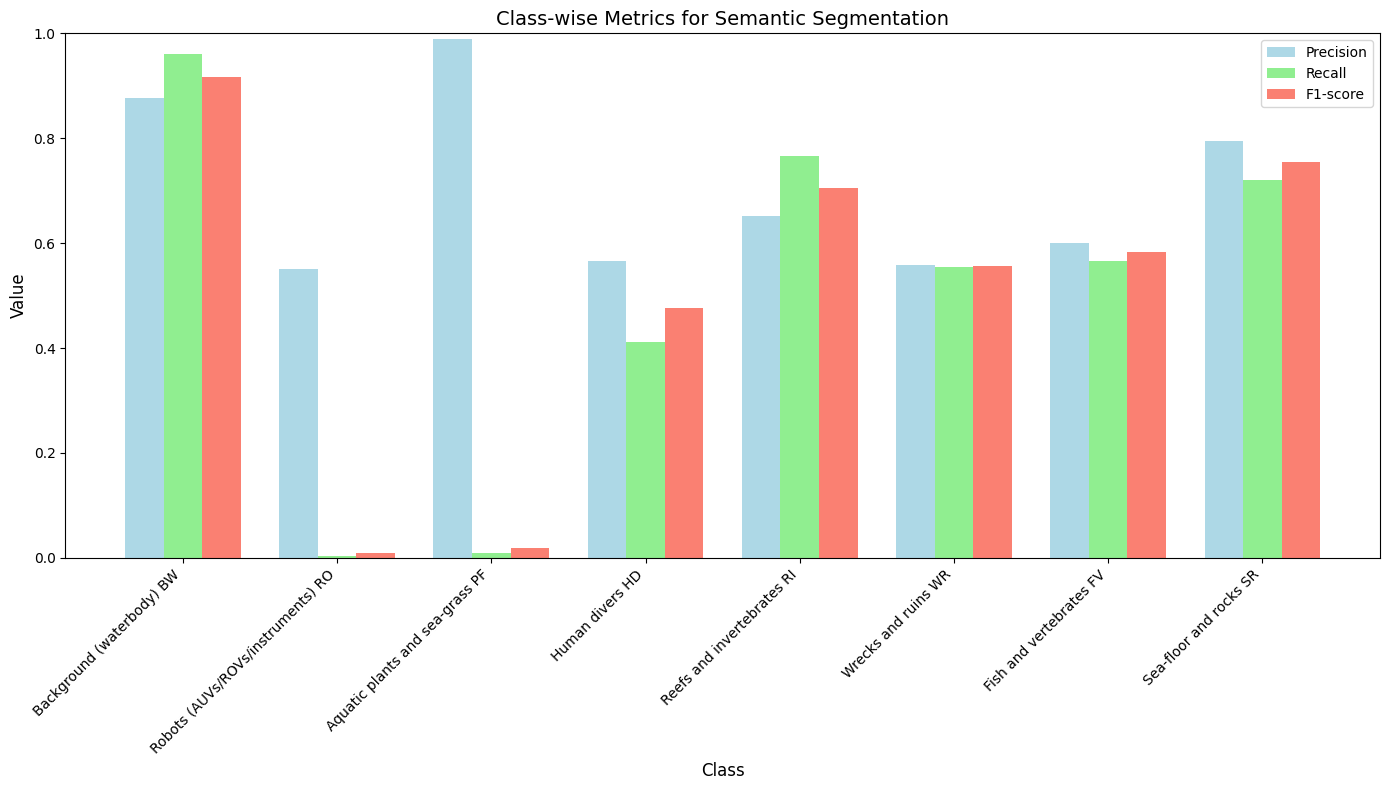

In [25]:
import matplotlib.pyplot as plt

# Dati per il grafico
global_metric_names = ["Micro Precision", "Micro Recall", "Micro F1-score", 
                       "Macro Precision", "Macro Recall", "Macro F1-score"]
global_metric_values = [micro_precision, micro_recall, micro_f1, 
                        macro_precision, macro_recall, macro_f1]

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))

# Barre per le metriche Micro
plt.bar(global_metric_names[:3], global_metric_values[:3], color='skyblue', edgecolor='black', label="Micro Metrics")

# Barre per le metriche Macro
plt.bar(global_metric_names[3:], global_metric_values[3:], color='lightcoral', edgecolor='black', label="Macro Metrics")

# Aggiungi etichette e titolo
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.ylim(0, 1)  # Le metriche sono tra 0 e 1
plt.title("Global Metrics for Semantic Segmentation", fontsize=14)

# Aggiungi valori sopra le barre
for i, v in enumerate(global_metric_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

# Aggiungi la legenda
plt.legend()

# Mostra il grafico
plt.show()

# Preparazione dei dati per il grafico
class_names = [class_dict.get(cls, f"Class {cls}") for cls in range(num_classes)]
precision_values = precision
recall_values = recall
f1_values = f1_score

x = range(len(class_names))  # Indici delle classi

# Creazione del grafico a barre raggruppate
plt.figure(figsize=(14, 8))
width = 0.25  # Larghezza delle barre

plt.bar([p - width for p in x], precision_values, width=width, label='Precision', color='lightblue')
plt.bar(x, recall_values, width=width, label='Recall', color='lightgreen')
plt.bar([p + width for p in x], f1_values, width=width, label='F1-score', color='salmon')

# Etichette asse x
plt.xticks(x, class_names, rotation=45, ha='right', fontsize=10)

# Aggiungi etichette e titolo
plt.xlabel("Class", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.ylim(0, 1)  # Le metriche sono tra 0 e 1
plt.title("Class-wise Metrics for Semantic Segmentation", fontsize=14)
plt.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()